In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
# Add the project root (toy-wm directory) to sys.path so we can import src as a package
# This allows relative imports within the package to work correctly
# Assumes notebook is run from the project root directory
project_root = os.getcwd()  # or use: os.path.dirname(os.path.abspath(''))
print(project_root)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

/share/u/wendler/code/toy-wm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch as t

# Import using absolute path from src package
from src.utils.checkpoint import load_model_from_config

model = load_model_from_config("configs/inference_f2f.yaml", strict=False)
model.eval()

loading configs/inference_f2f.yaml
loaded state dict


CausalDit(
  (rope_seq): VidRoPE()
  (blocks): ModuleList(
    (0-7): 8 x CausalBlock(
      (norm1): RMSNorm((396,), eps=None, elementwise_affine=True)
      (selfattn): Attention(
        (QKV): Linear(in_features=396, out_features=1188, bias=True)
        (O): Linear(in_features=396, out_features=396, bias=True)
        (lnq): RMSNorm((66,), eps=None, elementwise_affine=True)
        (lnk): RMSNorm((66,), eps=None, elementwise_affine=True)
        (rope): VidRoPE()
      )
      (norm2): RMSNorm((396,), eps=None, elementwise_affine=True)
      (geglu): GEGLU(
        (up_proj): Linear(in_features=396, out_features=1584, bias=True)
        (up_gate): Linear(in_features=396, out_features=1584, bias=True)
        (down): Linear(in_features=1584, out_features=396, bias=True)
        (nonlin): SiLU()
      )
      (modulation): Sequential(
        (0): SiLU()
        (1): Linear(in_features=396, out_features=2376, bias=True)
      )
    )
  )
  (patch): Patch(
    (init_conv_seq): Sequen

In [3]:
from src.inference import sample
from src.datasets.pong1m import get_loader

loader, pred2frame = get_loader(duration=1, fps=30)
frames, actions = next(iter(loader))

520 batches


In [4]:
inp_frames = frames

In [5]:
cache = model.create_cache(1)

In [6]:
from src.trainers.diffusion_forcing import sample

def render_video(start_frame, actions, n_steps=4, cfg=0, negative_actions=None, clamp=True, cache=cache):
    cache.reset()
    frames = t.zeros(1, actions.shape[1]+1, 3, 24, 24, device="cpu")
    frames[:, :1] = start_frame.detach().cpu()
    for aidx in range(actions.shape[1]):
        print(aidx)
        prev_frame = frames[:, aidx:aidx+1].to(model.device) 
        z = sample(model, prev_frame, actions[:, aidx:aidx+1], num_steps=n_steps, cfg=cfg, negative_actions=negative_actions, cache=cache)
        frames[:, aidx+1:aidx+2] = z.detach().cpu()
        if clamp:
            frames = frames.clamp(-1, 1)
    return frames

In [7]:
model

CausalDit(
  (rope_seq): VidRoPE()
  (blocks): ModuleList(
    (0-7): 8 x CausalBlock(
      (norm1): RMSNorm((396,), eps=None, elementwise_affine=True)
      (selfattn): Attention(
        (QKV): Linear(in_features=396, out_features=1188, bias=True)
        (O): Linear(in_features=396, out_features=396, bias=True)
        (lnq): RMSNorm((66,), eps=None, elementwise_affine=True)
        (lnk): RMSNorm((66,), eps=None, elementwise_affine=True)
        (rope): VidRoPE()
      )
      (norm2): RMSNorm((396,), eps=None, elementwise_affine=True)
      (geglu): GEGLU(
        (up_proj): Linear(in_features=396, out_features=1584, bias=True)
        (up_gate): Linear(in_features=396, out_features=1584, bias=True)
        (down): Linear(in_features=1584, out_features=396, bias=True)
        (nonlin): SiLU()
      )
      (modulation): Sequential(
        (0): SiLU()
        (1): Linear(in_features=396, out_features=2376, bias=True)
      )
    )
  )
  (patch): Patch(
    (init_conv_seq): Sequen

In [ ]:
actions = t.tensor([40*[2]], dtype=t.int32, device=model.device)
z = render_video(inp_frames[:1, :1], actions, n_steps=100, cfg=0, negative_actions=None, clamp=False)
frames = pred2frame(z)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


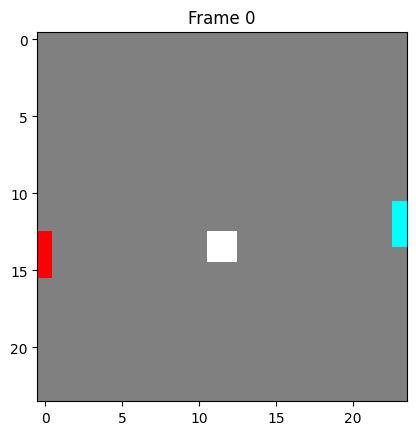

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# z[0] shape: (num_frames, height, width, 3), where num_frames = frames.shape[1]
frames_np = frames[0].permute(0, 2, 3, 1).cpu().numpy()  # shape: (num_frames, height, width, 3)

fig, ax = plt.subplots()
im = ax.imshow(frames_np[0])
ax.set_title('Frame 0')

def animate(i):
    im.set_data(frames_np[i])
    ax.set_title(f'Frame {i}')
    return [im]

ani = animation.FuncAnimation(
    fig, animate, frames=frames_np.shape[0],
    interval=200, blit=True, repeat=True
)

plt.show()

# Optional: To save the gif uncomment below (requires pillow, install with `pip install pillow`)
from collections import Counter
# Majority vote over values in actions for the filename
if actions is not None:
    # Flatten actions tensor and convert to list
    action_vals = actions.flatten().tolist()
    majority_val = Counter(action_vals).most_common(1)[0][0]
    ani.save(f"sample_{majority_val}.gif", writer="pillow")
else:
    ani.save("sample_unknown.gif", writer="pillow")